In [2]:
!pip install tensorflow


  Using cached tensorflow-2.7.0-cp38-cp38-win_amd64.whl (430.8 MB)


# 실패

In [3]:
import FinanceDataReader as fdr #주식데이터 불러오기
import OpenDartReader # 주식데이터 openapi 사용툴
import pandas as pd # 데이터저장
import matplotlib as mpl # 시각화
import matplotlib.pyplot as plt # 시각화
import matplotlib.font_manager as fm # 한글폰트 적용
import seaborn as sns # 시각화
import numpy as np
import tensorflow.compat.v1 as tf # 2버전 사용시 placehoder 사용못하게 되어 1버전으로 변경

font_path = r'C:\Windows\Fonts\NanumBarunGothic.ttf' # 한글폰트 경로

In [4]:
import warnings
warnings.filterwarnings('ignore')
#오류 제거

In [9]:
df = fdr.DataReader(symbol='005930',start='2019')  
# symbol : 종목코드 , 무조건 6자리 사용
# 시작점 미설정시 : 상장일부터
# 종료점 미설정시 : 현재일까지
df = df[['Open','High','Low','Change','Close','Volume']]  # 계산을 편리성을 위해  종가,거래량을 맨뒤로 보냄(칼럼 재배치)
df

,Open,High,Low,Change,Close,Volume
Date,,,,,,
2019-01-02,39400,39400,38550,0.001292,38750,7847664
2019-01-03,38300,38550,37450,-0.029677,37600,12471493
2019-01-04,37450,37600,36850,-0.003989,37450,14108958
2019-01-07,38000,38900,37800,0.034713,38750,12748997
2019-01-08,38000,39200,37950,-0.016774,38100,12756554
...,...,...,...,...,...,...
2021-11-04,71200,71600,70500,0.002841,70600,11818987
2021-11-05,71600,71600,70200,-0.005666,70200,12667743
2021-11-08,70400,70600,69800,0.005698,70600,11121981


In [6]:
# 정규화 함수
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7)  # 1e-7를 더하는 이유 : 0으로 나누는 오류 방지

#역정규화 : 정규화된 값을 원래의 값으로 되돌림    => 딥러닝후 내일 예측값을 되돌릴때 사용
def reverse_min_max_scaling(org_x,x): 
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(org_x)
    return (x_np *(org_x_np.max()-org_x_np.min()+1e-7)) + org_x_np.min()

In [20]:
input_dcm_cnt = 6 # 입력데이터 칼럼 갯수
output_dcm_cnt = 1 # 결과데이터 칼럼 갯수

seq_length = 30 # 시계열데이터 입력갯수(시퀸스의 길이)
rnn_cell_hidden_dim = 20 #각 셀의 히든 출력 크기

forget_bias = 1.0 
# 망각편향(= 시그모이드) : 셀 스테이트에서 어떤 값을 제어할지 선택하는 값
# 0 일경우 예측에 영향을 주지않도록 버리며, 1일 경우  의미있는값으로 판단하여 셀 스테이트값에 넣어주는 형식
# 셀 스테이트는 다이어그램 상단에 위치한 수평선이다. ( 진행 과정 

num_df_layers = 1 
# 층갯수

keep_prob = 1.0
# 유지확률
epoch_num = 1000 #반복학습 횟수
learning_rate = 0.01 # 학습률

In [21]:
# 거래량을 제외한 나머지 정규화 시킴

df_info = df.values[1:].astype(np.float)

price = df_info[:,:-1]  # 거래량 제외 나머지 들고오기
norm_price = min_max_scaling(price) # 위에 정규화함수를 사용하여 정규화시킴
norm_price.shape # 행, 열 갯수 확인

(5395, 5)

In [22]:
norm_price # 정규화 됬는지 확인

array([[5.99186914e-02, 6.26046380e-02, 5.70261335e-02, 5.25031210e-07,
        5.76459673e-02],
       [5.94021632e-02, 5.97120801e-02, 5.76459673e-02, 1.49518999e-06,
        5.80591899e-02],
       [5.74393560e-02, 5.85757181e-02, 5.53732433e-02, 1.27408148e-06,
        5.72327448e-02],
       ...,
       [7.27273115e-01, 7.29339228e-01, 7.21074777e-01, 1.47999938e-06,
        7.29339228e-01],
       [7.26240058e-01, 7.33471453e-01, 7.24173946e-01, 1.40650324e-06,
        7.28306171e-01],
       [7.26240058e-01, 7.32438397e-01, 7.25207002e-01, 1.39182920e-06,
        7.26240058e-01]])

In [23]:
# 거래량만 따로 정큐화 시킴
volume = df_info[:,-1:]   # 거래량 칼럼만 빼온다
norm_volume = min_max_scaling(volume) # 정규화
norm_volume.shape  # 행,열 갯수 확인

(5395, 1)

In [24]:
norm_volume # 정규화 됬는지 확인

array([[0.01653933],
       [0.0120458 ],
       [0.00892735],
       ...,
       [0.12315859],
       [0.12357504],
       [0.06425771]])

In [25]:
x = np.concatenate((norm_price, norm_volume), axis=1)   # 훈련을 위해 데이터 합침 
y = x[:,[-2]]   # 종가 데이터만 따로 들고 옴 ( 종가 = 결과값 )

dataX = []   # 한달단위로 데이터를 쪼갠 데이터를 넣기 위한
dataY = []   # 빈 리스트 생성

for i in range(0, len(y) - seq_length):  # 앞에 seq_length =30 으로 입력 달로 나누기위해
    x1 = x[i:i+seq_length]
    y1 = y[i+seq_length]
    dataX.append(x1)
    dataY.append(y1)
    
train_size = int(len(dataY)*0.8)
test_size = len(dataY)-train_size

In [26]:
print(test_size) # 사이즈 크기확인
print(train_size)

1073
4292


In [27]:
# trian & test 데이터 분류
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(trainX.shape[1], trainX.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [33]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(trainX, trainY, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(testX, testY), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
257/269 [===========================>..] - ETA: 0s - loss: 0.0090
Epoch 00001: val_loss improved from inf to 0.74293, saving model to model\tmp_checkpoint.h5
269/269 [==============================] - 2s 5ms/step - loss: 0.0086 - val_loss: 0.7429
Epoch 2/200
261/269 [============================>.] - ETA: 0s - loss: 5.8993e-05
Epoch 00002: val_loss improved from 0.74293 to 0.56924, saving model to model\tmp_checkpoint.h5
269/269 [==============================] - 1s 4ms/step - loss: 5.8589e-05 - val_loss: 0.5692
Epoch 3/200
256/269 [===========================>..] - ETA: 0s - loss: 4.2954e-05
Epoch 00003: val_loss improved from 0.56924 to 0.47956, saving model to model\tmp_checkpoint.h5
269/269 [==============================] - 1s 4ms/step - loss: 4.3151e-05 - val_loss: 0.4796
Epoch 4/200
265/269 [============================>.] - ETA: 0s - loss: 4.2486e-05
Epoch 00004: val_loss improved from 0.47956 to 0.36371, saving model to model\tmp_checkpoint.h5
269/269 [============

In [35]:
model.load_weights(filename)
pred = model.predict(testX)

pred.shape

(1073, 1)

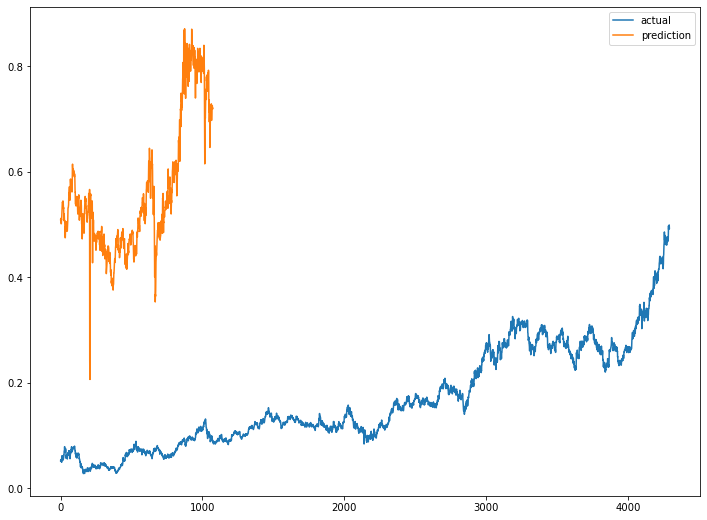

In [37]:
plt.figure(figsize=(12, 9))
plt.plot(trainY, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,precision_recall_curve,roc_auc_score # 정확도 평가 방법

In [40]:

def get_clf_eval(y_test,pred):
        confusion = confusion_matrix(testY,pred)
        accuracy = accuracy_score(testY,pred)
        precision = precision_score(testY,pred,average='weighted')
        recall = recall_score(testY,pred,average='weighted')
        f1 = f1_score(testY,pred,average='weighted')
        print('오차행렬')
        print(confusion)

        print(f'정확도:{accuracy:.4f} 정밀도:{precision:.4f} 재현율:{recall:.4f} F1:{f1:.4f}')

In [42]:
get_clf_eval(testY,pred)

ValueError: continuous is not supported

In [28]:
# #placeholder : 처음에 변수를 선언 할때 바로 값을 주는 것이 아니라 나중에 값을 던저주는 공간을 만들어주는 것

# X = tf.placeholder(tf.float32, [None,seq_length, input_dcm_cnt]) #dtype 설정 안할경우 에러방생
# Y = tf.placeholder(tf.float32, [None,1])
# #print(X) # 값확인
# #print(Y)

# target = tf.placeholder(tf.float32, [None, 1])  # 훈련데이터 분류
# pred = tf.placeholder(tf.float32, [None, 1])
# #print(target) #값확인
# #print(pred)

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [ ]:
# LSTM_RNN 버전을 함수로 설정
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, # 아웃풋 크기 설정
                                       forget_bias=forget_bias, # 망각편향값 1 디폴트값
                                       state_is_tuple=True,
                                       activation=tf.nn.softsign) 
    if keep_prob < 1.0 :
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob) # 오래걸리는 경우의 방법은 삭제해준다.
    return cell

In [ ]:
stackedRNNs = [lstm_cell()for _ in range(num_df_layers)] #df LSTM Layers 개수 1  위에서 설정
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True)if num_stacked_layers > 1 else lstm_cell()

hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:,-1], output_dcm_cnt, activation_fn=tf.identity)
hypothesis.shape

ImportError: cannot import name 'to_categorical' from 'keras.utils' (C:\Users\admin\anaconda3\lib\site-packages\keras\utils\__init__.py)